In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [18]:
transform = transforms.Compose([
        transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


In [19]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Ensures output is in [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Function to add noise to images
def add_noise(images, noise_factor=0.5):
    noise = noise_factor * torch.randn_like(images)
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.)

# Training function
def train_autoencoder(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            original_images, _ = data
            noisy_images = add_noise(original_images).to(device)  # Add noise and clamp
            original_images = original_images.to(device)

            optimizer.zero_grad()
            outputs = model(noisy_images)
            loss = criterion(outputs, original_images)  # Compare outputs to clean images
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")



In [20]:
model = Autoencoder().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_autoencoder(model, train_loader, criterion, optimizer, epochs=5)

Epoch [1/5], Loss: 0.2367
Epoch [2/5], Loss: 0.1261
Epoch [3/5], Loss: 0.1114
Epoch [4/5], Loss: 0.1057
Epoch [5/5], Loss: 0.1027


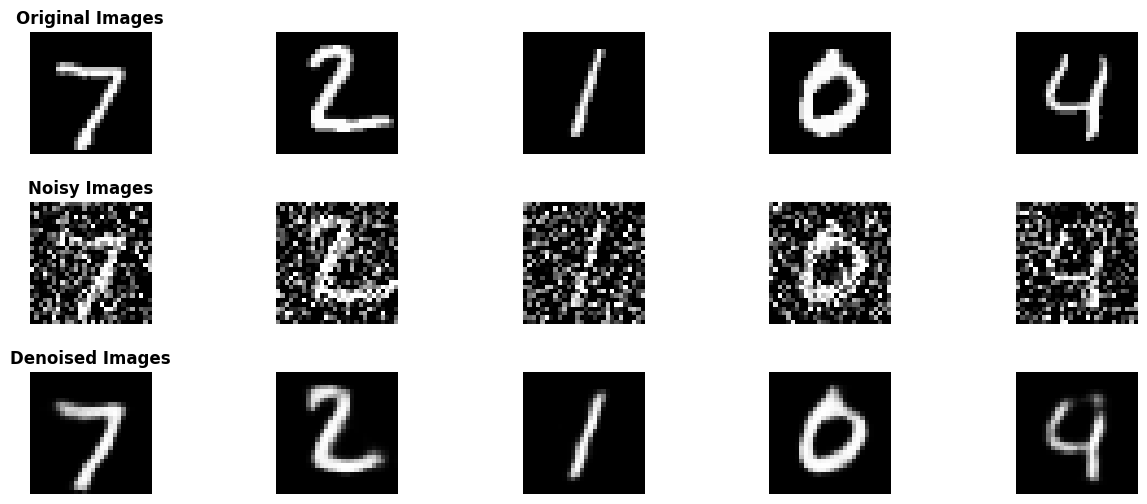

In [23]:
# Improved Evaluation Function with more appealing plotting
def evaluate_autoencoder(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        data_iter = iter(test_loader)
        images, labels = next(data_iter)
        noisy_images = add_noise(images).to(device)

        # Get model output (denoised images)
        denoised_images = model(noisy_images)

        # Plotting noisy, original, and denoised images with better layout and style
        fig, axes = plt.subplots(3, 5, figsize=(15, 6))  # 3 rows for Original, Noisy, and Denoised images
        fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust spacing between subplots

        titles = ["Original Images", "Noisy Images", "Denoised Images"]

        for i in range(5):
            # Original Images
            ax = axes[0, i]
            ax.imshow(images[i].cpu().numpy().reshape(28, 28), cmap="gray")
            ax.axis('off')
            if i == 0:
                ax.set_title(titles[0], fontsize=12, fontweight='bold')

            # Noisy Images
            ax = axes[1, i]
            ax.imshow(noisy_images[i].cpu().numpy().reshape(28, 28), cmap="gray")
            ax.axis('off')
            if i == 0:
                ax.set_title(titles[1], fontsize=12, fontweight='bold')

            # Denoised Images
            ax = axes[2, i]
            ax.imshow(denoised_images[i].cpu().numpy().reshape(28, 28), cmap="gray")
            ax.axis('off')
            if i == 0:
                ax.set_title(titles[2], fontsize=12, fontweight='bold')

        plt.show()

# Call the evaluation function
evaluate_autoencoder(model, test_loader)
